<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [2]:
# %matplotlib widget
%matplotlib inline

In [3]:
!pip install gpytorch


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Gaussian Process

In [4]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [5]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=17


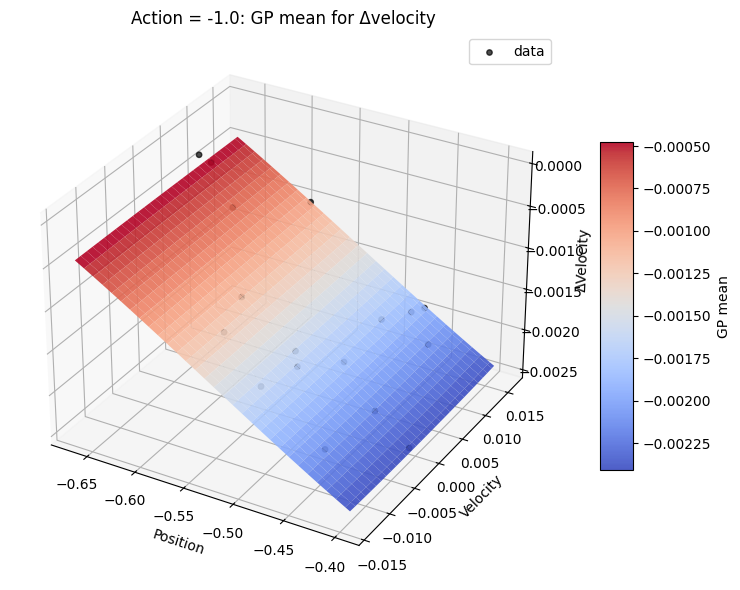

Plotting for action a=0.0
Values near action a=0.0 n=34


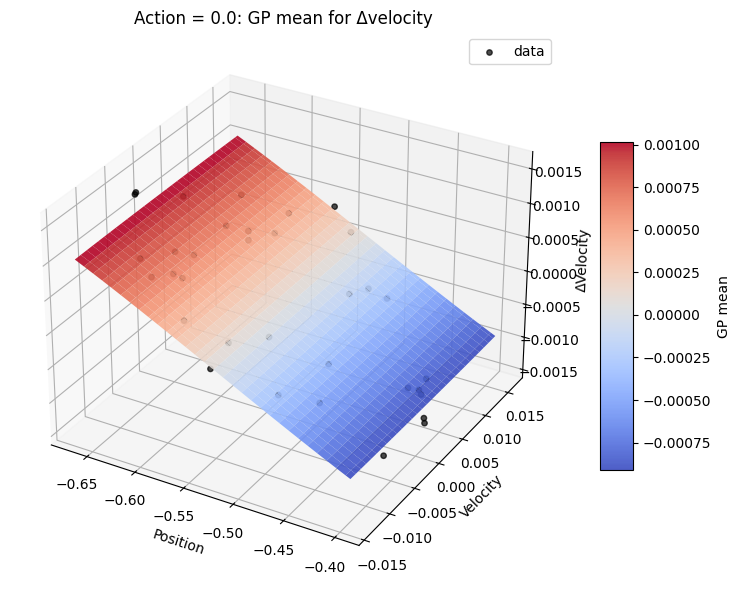

Plotting for action a=1.0
Values near action a=1.0 n=16


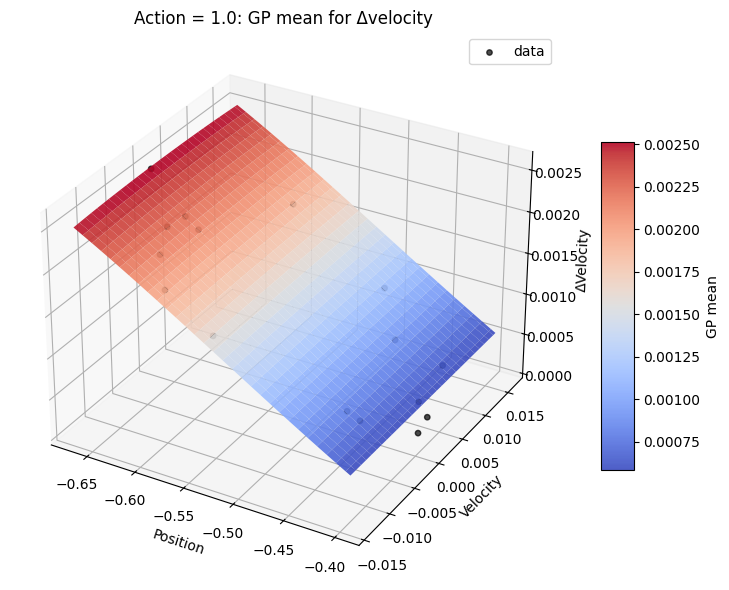

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=17


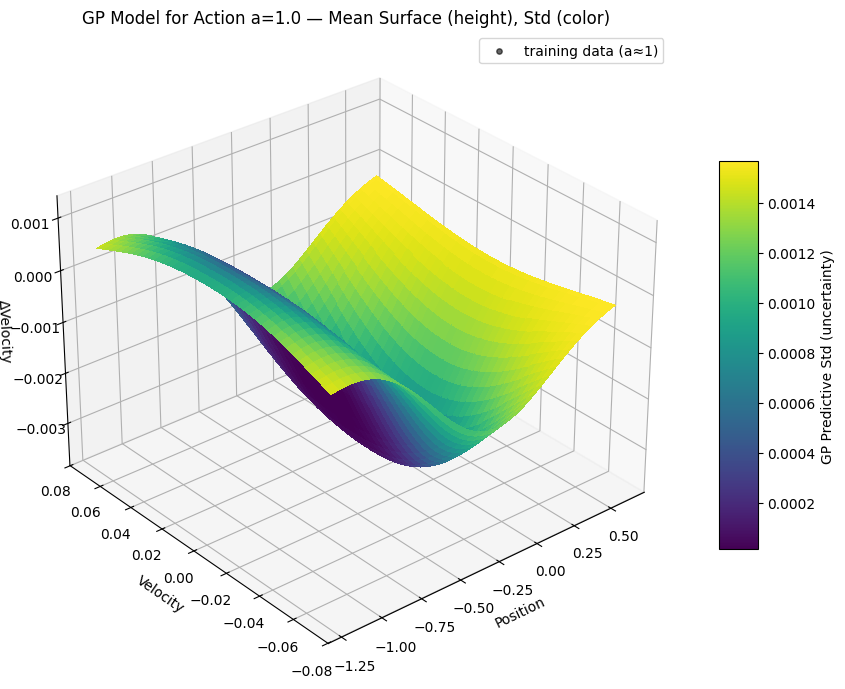

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


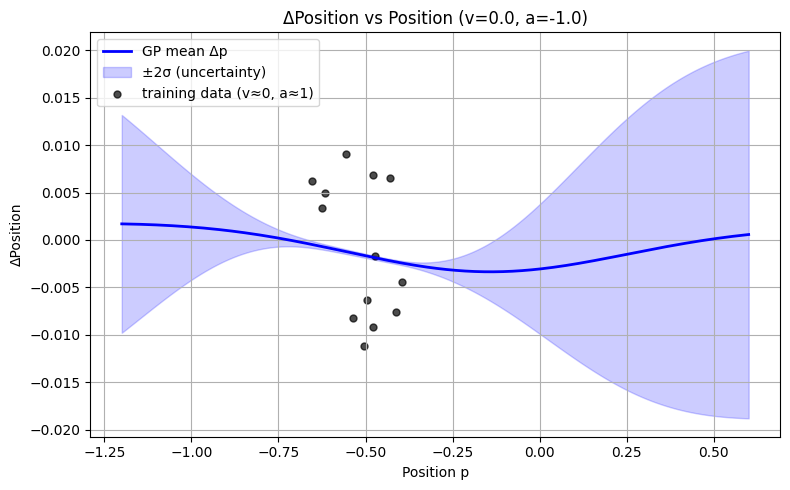

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


In [9]:
# def plot_trajectories(state, best_traj):
#     plt.figure(figsize=(8, 6))
#     for i, traj in enumerate(best_traj):
#         plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
#     plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
#     plt.axvline(0.5, color='gray', ls='--', label='Goal position')
#     plt.xlabel("Position")
#     plt.ylabel("Velocity")
#     plt.title(f"Predicted Trajectories (Continuous MPC)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
#
# def cost_fn(state, a):
#     x, v = state
#     goal = 0.5
#     target = goal - x
#
#     # Encourage moving in the right direction and gaining kinetic energy
#     cost = target**2 - 1000 * np.abs(v)
#     return cost
#
# def roll_out_trajectory(s0, Ui, gamma=1.0):
#     s = s0.copy()  # Initial state
#     traj = [s0.copy()]  # Trajectory
#     H = len(Ui)
#     discount = 1.0
#
#     total_cost = 0.0
#
#     # For each time in the planning horizon
#     for k in range(H):
#         a = Ui[k]  # continuous action in [-1, 1]
#         delta_m = np.zeros(2)
#
#         # Predict Δx using both GPs (for Δp, Δv)
#         inp_data = np.array([(s[0], s[1], a),])
#         dp, _ = gps[0].predict(inp_data)
#         dv, _ = gps[1].predict(inp_data)
#         s += np.array((dp[0], dv[0]))
#
#         traj.append(s.copy())
#
#         # Accumulate discounted cost
#         total_cost += cost_fn(s, a) * discount
#         discount *= gamma
#     return np.array(traj), total_cost
#
#
# def roll_out_n_trajectories(state, U):
#     N_seq = len(U)
#     J = np.zeros(N_seq)
#
#     # Roll out trajectories and computer their cost
#     all_traj = []
#     for i in range(N_seq):
#         traj, total_cost = roll_out_trajectory(state, U[i])
#
#         J[i] = total_cost
#         all_traj.append(np.array(traj))
#
#     return all_traj, J
#
# import numpy as np
# # Action squence
# Ui = np.zeros(3)
# traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
# traj

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        inp_data = np.array([(s[0], s[1], a),])
        dp, _ = gps[0].predict(inp_data)
        dv, _ = gps[1].predict(inp_data)
        s += np.array((dp[0], dv[0]))

        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

import numpy as np
# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0
        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        action_sequences = self.U_mean + noise


        # 2. Roll out trajectories
        all_traj, all_cost = roll_out_n_trajectories(state, action_sequences)

        # 4-under-grad. Select the best trajectory (lowest cost)
        ranked_trajectories = sorted(zip(all_cost, all_traj, action_sequences), key=lambda x: x[0])
        # self.U_mean = ranked_trajectories[0][2]

        # 4-grad. Compute weights (importance weights)
        min_cost = np.min(all_cost)
        weights = np.exp(-(all_cost - min_cost) / self.λ)
        weights /= np.sum(weights)
        weighted_noise = np.sum(weights[:, None] * noise, axis=0)
        self.U_mean += weighted_noise


        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(all_cost)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 5. Return the first action of the best sequence
        best_action = ranked_trajectories[0][2][0]
        return best_action


def mpc_action():
    # Init ialize controller once
    mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)
    obs, _ = env.reset()
    def temp_func(state, plot_traj_flag):
        obs = state
        a = mppi.action(obs, plot=plot_traj_flag, plot_best=3)  # plot first iteration only
        return a
    return temp_func

PLOT_TRAJ = False
done = False
positions = list()
rewards = list()
find_best_action = mpc_action()

step = 0
while not done:
    plot_traj_flag = True if step % 10 == 0 and PLOT_TRAJ else False
    a = find_best_action(obs, plot_traj_flag=plot_traj_flag)
    obs, r, terminated, truncated, info = env.step(np.array([a], dtype=np.float32))
    positions.append(obs[0])
    rewards.append(r)
    done = terminated or truncated
    step += 1
    if plot_traj_flag or step % 10 == 0:
        print(f"Step: {step}, position: {positions[-1]:.4f}, action: {a:.4f} total reward: {np.sum(rewards):.2f}")
    if step >= 1000 or truncated or terminated:
        break

print(f"Episode steps: {step}, total reward: {np.sum(rewards):.2f}")


Step: 10, position: -0.5881, action: -4.9569 total reward: -16.02
Step: 20, position: -0.6886, action: -3.9996 total reward: -36.93
Step: 30, position: -0.7228, action: 7.8433 total reward: -122.52
Step: 40, position: -0.5853, action: -7.5688 total reward: -244.51
Step: 50, position: -0.3509, action: 3.6230 total reward: -406.70
Step: 60, position: -0.0975, action: 5.0732 total reward: -583.14
Step: 70, position: 0.0309, action: 3.8655 total reward: -817.90
Step: 80, position: -0.0447, action: -5.1888 total reward: -1140.37
Step: 90, position: -0.3808, action: 16.4790 total reward: -1724.81
Step: 100, position: -0.8388, action: -8.5137 total reward: -1883.54
Step: 110, position: -1.1647, action: 22.8672 total reward: -2097.53
Step: 120, position: -1.1129, action: 0.3586 total reward: -2381.15
Step: 130, position: -0.7590, action: -14.0246 total reward: -2592.87
Step: 140, position: -0.2425, action: 3.3624 total reward: -3193.85
Step: 150, position: 0.1159, action: -9.3737 total reward:

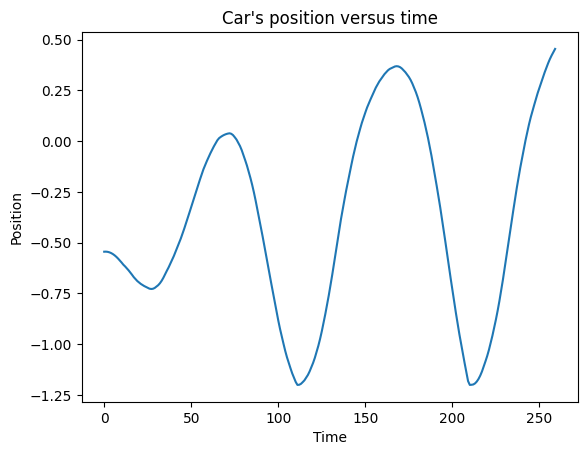

In [11]:
plt.plot(positions)
plt.title("Car's position versus time")
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()


# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

UNCERTAINTY_PENALTY = 1

def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def cost_fn(state, a, uncert = 0.0):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)

    cost += UNCERTAINTY_PENALTY * uncert
    return cost


def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        inp_data = np.array([(s[0], s[1], a),])
        dp, dp_var = gps[0].predict(inp_data)
        dv, dv_var = gps[1].predict(inp_data)
        s += np.array((dp[0], dv[0]))

        traj.append(s.copy())

        step_uncertainty = dp_var[0] + dv_var[0]


        # Accumulate discounted cost
        step_cost = cost_fn(s, a, step_uncertainty)
        total_cost +=  step_cost * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

import numpy as np
# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0
        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        action_sequences = self.U_mean + noise


        # 2. Roll out trajectories
        all_traj, all_cost = roll_out_n_trajectories(state, action_sequences)

        # 4-under-grad. Select the best trajectory (lowest cost)
        ranked_trajectories = sorted(zip(all_cost, all_traj, action_sequences), key=lambda x: x[0])
        # self.U_mean = ranked_trajectories[0][2]

        # 4-grad. Compute weights (importance weights)
        min_cost = np.min(all_cost)
        weights = np.exp(-(all_cost - min_cost) / self.λ)
        weights /= np.sum(weights)
        weighted_noise = np.sum(weights[:, None] * noise, axis=0)
        self.U_mean += weighted_noise


        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(all_cost)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 5. Return the first action of the best sequence
        best_action = ranked_trajectories[0][2][0]
        return best_action


def mpc_action():
    # Init ialize controller once
    mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)
    obs, _ = env.reset()
    def temp_func(state, plot_traj_flag):
        obs = state
        a = mppi.action(obs, plot=plot_traj_flag, plot_best=3)  # plot first iteration only
        return a
    return temp_func

PLOT_TRAJ = False
done = False
positions = list()
rewards = list()
find_best_action = mpc_action()

step = 0
while not done:
    plot_traj_flag = True if step % 10 == 0 and PLOT_TRAJ else False
    a = find_best_action(obs, plot_traj_flag=plot_traj_flag)
    obs, r, terminated, truncated, info = env.step(np.array([a], dtype=np.float32))
    positions.append(obs[0])
    rewards.append(r)
    done = terminated or truncated
    step += 1
    if plot_traj_flag or step % 10 == 0:
        print(f"Step: {step}, position: {positions[-1]:.4f}, action: {a:.4f} total reward: {np.sum(rewards):.2f}")
    if step >= 1000 or truncated or terminated:
        break

print(f"Episode steps: {step}, total reward: {np.sum(rewards):.2f}")


Step: 10, position: -0.5672, action: 3.7209 total reward: -26.85
Step: 20, position: -0.4213, action: 3.2274 total reward: -59.56
Step: 30, position: -0.2516, action: 6.6493 total reward: -139.52
Step: 40, position: -0.2508, action: 6.0886 total reward: -182.63
Step: 50, position: -0.5028, action: -2.7321 total reward: -216.47
Step: 60, position: -0.8941, action: -12.4788 total reward: -311.84
Step: 70, position: -1.1680, action: -6.5548 total reward: -660.53
Step: 80, position: -1.1365, action: 13.3356 total reward: -805.55
Step: 90, position: -0.7826, action: -50.2752 total reward: -1216.53
Step: 100, position: -0.2571, action: 2.2968 total reward: -1442.09
Step: 110, position: 0.1941, action: -19.0870 total reward: -1753.99
Episode steps: 118, total reward: -1756.88


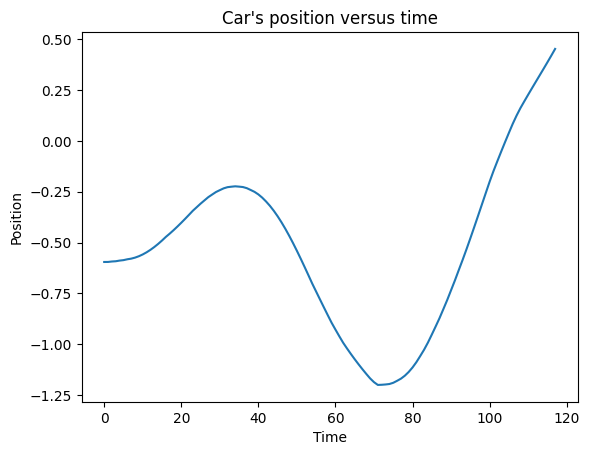

In [15]:
plt.plot(positions)
plt.title("Car's position versus time")
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

# Discussion:

In the first version of the controller, where MPPI uses only the GP mean prediction, the system is able to solve the Mountain Car problem, but it usually needs more than 100 steps to reach the goal. This happens because the controller relies only on the “average” prediction of the GP model. When the GP has not seen enough data in some regions of the state space, its predictions may be inaccurate. As a result, MPPI may choose actions that look good according to the model but are actually not very effective in practice. This often causes slow progress or unnecessary oscillations before the car gains enough momentum to reach the top.

When we include the GP variance in the cost function, the controller becomes aware of the uncertainty in its model predictions. In other words, trajectories that pass through states where the GP is unsure (high variance) receive an extra penalty. This encourages the planner to choose actions that keep the system in regions where the model is more reliable. Based on the experiments, this uncertainty-aware version of MPPI usually reaches the goal faster and more consistently. Considering the variance led to higher reward and less number of steps.